# Example - Analyzing Corporate Bond Data

## Introduction

In this example, we'll explore pulling corporate bond return data from WRDS, and running an analysis of returns based on the credit rating.

## Imports

we start with establishing the modules required for this example. Set the `WRDS_USERNAME` environment variable below to your WRDS username.

In [10]:
import finm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime

WRDS_USERNAME = "jszajkowski"


## Pull Corporate Bond Data

Next, we will use the `pull_WRDS_corp_bond_monthly` function to pull the corporate bond data from WRDS. Refer to the docstring of the function for the parameters and fields that are included in the data from WRDS.

In [11]:
# Download and save the corporate bond data
df = finm.pull_WRDS_corp_bond_monthly(
    start_date="2020-01-01",
    end_date="2020-12-31",
    wrds_username=WRDS_USERNAME,
)

path = "./WRDS_Corp_Bond_Monthly.parquet"
df.to_parquet(path)

Loading library list...
Done


## Load Data

Next, we will load the bond data.

In [12]:
# Load data and display
df = finm.load_WRDS_corp_bond_monthly(data_dir=".")
display(df)

,date,cusip,company_symbol,bond_type,price_eom,price_ldm,price_l5m,ret_eom,ret_ldm,ret_l5m,r_sp,r_mr,r_fr,n_sp,n_mr,n_fr,rating_num,rating_cat,rating_class
0,2020-01-31,00077TAA2,BNPQF,CDEB,115.00002,115.00002,115.00002,0.021262,<NA>,<NA>,BB+,BA2,A-,11.0,12.0,7.0,11.0,BB,1.HY
1,2020-02-29,00077TAA2,BNPQF,CDEB,114.66,<NA>,<NA>,0.002364,<NA>,<NA>,BB+,BA2,A-,11.0,12.0,7.0,11.0,BB,1.HY
2,2020-03-31,00077TAA2,BNPQF,CDEB,108.623,<NA>,<NA>,-0.046008,<NA>,<NA>,BB+,BA2,A-,11.0,12.0,7.0,11.0,BB,1.HY
3,2020-04-30,00077TAA2,BNPQF,CDEB,106.485141,<NA>,<NA>,-0.013457,<NA>,<NA>,BB+,BA2,A-,11.0,12.0,7.0,11.0,BB,1.HY
4,2020-05-31,00077TAA2,BNPQF,CDEB,106.485141,<NA>,<NA>,0.006079,<NA>,<NA>,BB+,BA2,A-,11.0,12.0,7.0,11.0,BB,1.HY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290826,2020-08-31,91412NAZ3,UOCH,CDEB,114.297333,<NA>,<NA>,0.002882,<NA>,<NA>,NR,AA2,NR,<NA>,3.0,<NA>,3.0,AA,0.IG
290827,2020-09-30,91412NAZ3,UOCH,CDEB,114.297333,<NA>,<NA>,0.002781,<NA>,<NA>,NR,AA2,NR,<NA>,3.0,<NA>,3.0,AA,0.IG
290828,2020-10-31,91412NAZ3,UOCH,CDEB,114.297333,<NA>,<NA>,0.002819,<NA>,<NA>,NR,AA2,NR,<NA>,3.0,<NA>,3.0,AA,0.IG
290829,2020-11-30,91412NAZ3,UOCH,CDEB,114.297333,<NA>,<NA>,0.002812,<NA>,<NA>,NR,AA2,NR,<NA>,3.0,<NA>,3.0,AA,0.IG


## Filter Data By Credit Rating

Next, we will investigate the data based on the `r_sp` column, which is the:

- (r_sp) S&P Bond Issue Credit Rating

Here we can identify the counts for each of the ratings:

In [31]:
# Isolate the ratings counts for r_sp
r_sp_ratings_counts = df['r_sp'].value_counts().sort_index()
r_sp_ratings_counts

r_sp
A           13984
A+           7420
A-          15424
AA           1544
AA+           688
AA-          2925
AA/A-1+        10
AAA           767
B             832
B+           1248
B-            823
BB           2054
BB+          3559
BB-          2269
BBB         18355
BBB+        19114
BBB-        10491
C             123
CC             76
CCC           215
CCC+          399
CCC-          291
D             166
NR         177706
Name: count, dtype: Int64

And then plot the distribution:

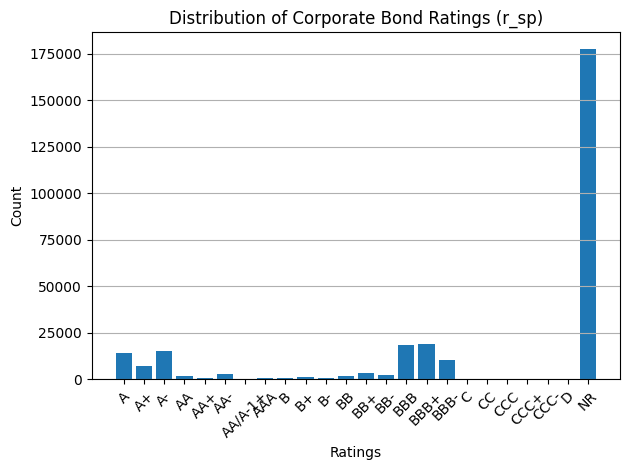

In [33]:
# Plot bar chart of ratings distribution
plt.bar(r_sp_ratings_counts.index, r_sp_ratings_counts.values)
plt.title('Distribution of Corporate Bond Ratings (r_sp)')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Interestingly, we can see that many of the rows 177,706 out of 290,831 do not have a rating.